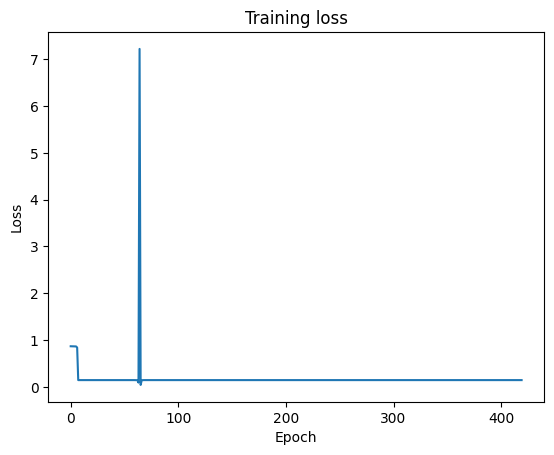

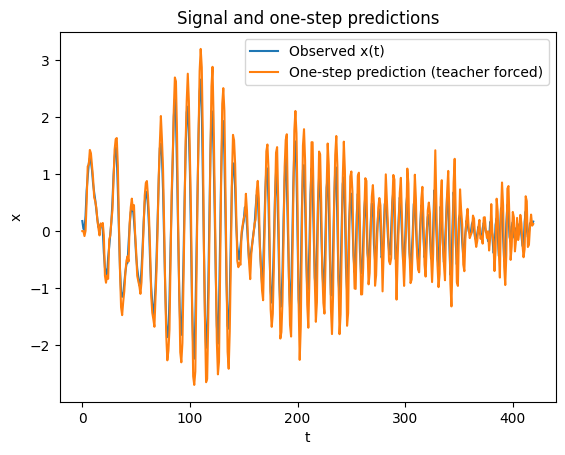

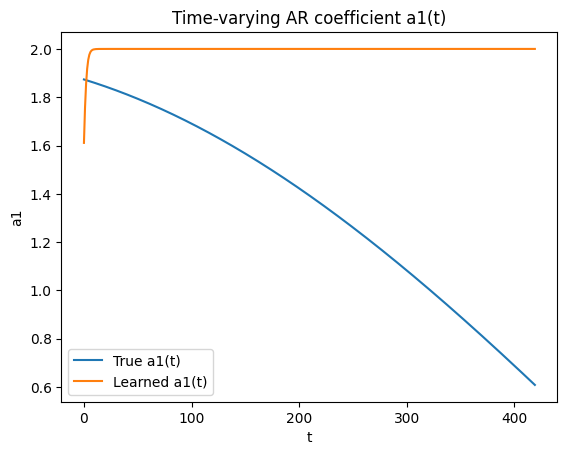

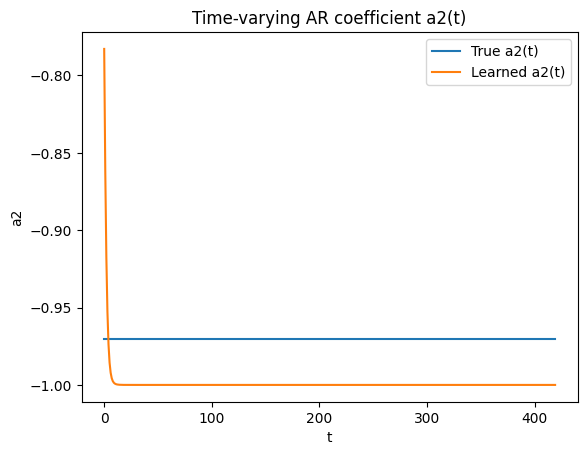

{'MSE(one-step)': 0.14533403515815735, 'corr(a1)': -0.1297433862854349, 'corr(a2)': nan}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# -----------------------------
# 1) Generate a small TV-AR(2) signal
# -----------------------------
T = 420
noise_std = 0.12

t = np.arange(T)
r = 0.985
theta0 = 0.10 * np.pi
theta1 = 0.40 * np.pi
theta = theta0 + (theta1 - theta0) * (t / (T - 1))

a1_true = 2 * r * np.cos(theta)
a2_true = -(r**2) * np.ones_like(a1_true)

x = np.zeros(T, dtype=np.float32)
x[0] = np.random.randn() * 0.1
x[1] = np.random.randn() * 0.1
for tt in range(2, T):
    x[tt] = a1_true[tt] * x[tt-1] + a2_true[tt] * x[tt-2] + noise_std * np.random.randn()

phi = np.stack([np.roll(x, 1), np.roll(x, 2)], axis=1).astype(np.float32)
phi[:2] = 0.0

# -----------------------------
# 2) Minimal Neural-ODE–TVAR(2) (Euler)
# -----------------------------
def levinson_order2(kappa):
    k1 = kappa[..., 0]
    k2 = kappa[..., 1]
    a2 = k2
    a1 = k1 * (1.0 - k2)
    return torch.stack([a1, a2], dim=-1)

class ODEFunc(nn.Module):
    def __init__(self, dim=2, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, dim),
        )
    def forward(self, z):
        return self.net(z)

class Encoder(nn.Module):
    def __init__(self, L=30, hidden=32, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(L, hidden),
            nn.Tanh(),
            nn.Linear(hidden, out_dim),
        )
    def forward(self, x0):
        return self.net(x0)

class NeuralODE_TVAR2(nn.Module):
    def __init__(self, L=30, hidden=32):
        super().__init__()
        self.L = L
        self.func = ODEFunc(dim=2, hidden=hidden)
        self.enc = Encoder(L=L, hidden=hidden, out_dim=2)

    def forward(self, x_seq, phi_seq, dt=1.0):
        T = x_seq.shape[0]
        z0 = self.enc(x_seq[:self.L].unsqueeze(0)).squeeze(0)  # (2,)

        z_list = [z0]
        for _ in range(1, T):
            z_prev = z_list[-1]
            z_next = z_prev + dt * self.func(z_prev)
            z_list.append(z_next)
        z = torch.stack(z_list, dim=0)

        kappa = torch.tanh(z)          # stable reflection coeffs in (-1,1)
        a = levinson_order2(kappa)     # stable AR(2) coeffs via LD recursion

        xhat = torch.zeros(T, device=x_seq.device)
        xhat[2:] = (a[2:] * phi_seq[2:]).sum(dim=1)
        return xhat, a, z

device = torch.device("cpu")
x_torch = torch.tensor(x, device=device)
phi_torch = torch.tensor(phi, device=device)

model = NeuralODE_TVAR2(L=30, hidden=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

lam_vel = 2e-3
lam_wd = 1e-6

loss_hist = []
epochs = 420
for epoch in range(epochs):
    optimizer.zero_grad()
    xhat, a_hat, z_hat = model(x_torch, phi_torch, dt=1.0)

    mse = ((x_torch[2:] - xhat[2:])**2).mean()
    dz = z_hat[1:] - z_hat[:-1]
    vel_pen = dz.pow(2).mean()

    wd = torch.tensor(0.0, device=device)
    for p_ in model.parameters():
        wd = wd + p_.pow(2).mean()

    loss = mse + lam_vel * vel_pen + lam_wd * wd
    loss.backward()
    optimizer.step()
    loss_hist.append(loss.item())

with torch.no_grad():
    xhat, a_hat, z_hat = model(x_torch, phi_torch, dt=1.0)
    a_hat_np = a_hat.cpu().numpy()
    xhat_np = xhat.cpu().numpy()

a_true = np.stack([a1_true, a2_true], axis=1).astype(np.float32)

# -----------------------------
# 3) Plots
# -----------------------------
plt.figure()
plt.plot(loss_hist)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(x, label="Observed x(t)")
plt.plot(xhat_np, label="One-step prediction (teacher forced)")
plt.title("Signal and one-step predictions")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

plt.figure()
plt.plot(a_true[:, 0], label="True a1(t)")
plt.plot(a_hat_np[:, 0], label="Learned a1(t)")
plt.title("Time-varying AR coefficient a1(t)")
plt.xlabel("t")
plt.ylabel("a1")
plt.legend()
plt.show()

plt.figure()
plt.plot(a_true[:, 1], label="True a2(t)")
plt.plot(a_hat_np[:, 1], label="Learned a2(t)")
plt.title("Time-varying AR coefficient a2(t)")
plt.xlabel("t")
plt.ylabel("a2")
plt.legend()
plt.show()

mse_val = float(np.mean((x[2:] - xhat_np[2:])**2))
corr_a1 = float(np.corrcoef(a_true[2:, 0], a_hat_np[2:, 0])[0, 1])
corr_a2 = float(np.corrcoef(a_true[2:, 1], a_hat_np[2:, 1])[0, 1])
print({"MSE(one-step)": mse_val, "corr(a1)": corr_a1, "corr(a2)": corr_a2})
